In [ ]:
import logging

import numpy as np
import skimage.morphology

from common.nifti import *
from common.plotting import *
from common.segmentation import *

In [ ]:
input_ct_path = lambda i: f"data/Case{i}_CT.nii.gz"
input_aorta_path = lambda i: f"data/Case{i}_Aorta.nii.gz"
input_l1_path = lambda i: f"data/Case{i}_L1.nii.gz"

In [ ]:
ct_data_list = []
ct_file_list = []
for i in range(1, 5 + 1):
    ct_data, ct_file = load_nifti_data(input_ct_path(i), return_file=True)
    ct_data_list.append(ct_data)
    ct_file_list.append(ct_file)

In [ ]:
aorta_data_list = []
aorta_file_list = []
for i in range(1, 5 + 1):
    aorta_data, aorta_file = load_nifti_data(input_aorta_path(i), return_file=True)
    aorta_data_list.append(aorta_data)
    aorta_file_list.append(aorta_file)

In [ ]:
l1_data_list = []
l1_file_list = []
for i in range(1, 4 + 1):
    l1_data, l1_file = load_nifti_data(input_l1_path(i), return_file=True)
    l1_data_list.append(l1_data)
    l1_file_list.append(l1_file)

In [ ]:
def show_sample_slices(case, slice_z):
    show(ct_data_list[case][:, :, slice_z])
    show(aorta_data_list[case][:, :, slice_z])
    show(l1_data_list[case][:, :, slice_z])

In [ ]:
show_sample_slices(3, 240)

In [ ]:
###############################################################################################################

In [ ]:
ct = ct_data_list[3]
aorta_GT = aorta_data_list[3]
l1 = l1_data_list[3]

In [ ]:
def find_largest_slice_layer(segmentation):
    # Calculate the area of each layer in the mask
    slice_areas = np.sum(segmentation, axis=(0, 1))

    # Find the layer with the largest area
    largest_layer = np.argmax(slice_areas)
    print(f"largest slice found at layer: {largest_layer}")

    # Extract the layer with the largest area from the mask
    return largest_layer

In [ ]:
def find_slice_centroid(slice):
    # Calculate the centroid of slice
    coords = np.where(slice)

    # Compute the mean coordinates along each axis
    x, y = np.mean(coords, axis=1).astype(int)
    return (x, y)


In [ ]:
################################
# Aorta segmentation procedure #
################################

# Find the largest slice of the L1 segmentation
key_layer = find_largest_slice_layer(l1)
key_l1 = l1[:, :, key_layer]

# Find that slice's centroid
x, y = find_slice_centroid(key_l1)

# Dirty previews
show(key_l1)

In [ ]:
a = np.zeros_like(l1[:, :, key_layer])
a[x - 5:x + 5, y - 5:y + 5] = 1
show(ct[:, :, key_layer] / 1000 + a + key_l1 + aorta_GT[:, :, key_layer])

In [ ]:
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull


def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    pi2 = np.pi / 2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points) - 1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)]).T
    #     rotations = np.vstack([
    #         np.cos(angles),
    #         -np.sin(angles),
    #         np.sin(angles),
    #         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    # best_idx = np.argmin(areas)
    best_idx = np.argmax(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [ ]:
def get_bounding_points(key_l1):
    points = np.transpose(np.where(key_l1))
    bounding_points = minimum_bounding_rectangle(points)
    bounding_points = [(int(p[1]), int(p[0])) for p in bounding_points]
    return bounding_points

In [ ]:
def plot_largest_bounding_box(bounding_points, key_ct, key_l1, key_aorta):
    polygon = Polygon(bounding_points, closed=True, facecolor="none", edgecolor="r", linewidth=1)
    # Create a figure and axes object
    fig, ax = plt.subplots()

    # Plot the image on the axes
    ax.imshow(key_ct + key_l1 + key_aorta, cmap="gray_r")

    # Use the fill function to plot the polygon on the image
    ax.add_patch(polygon)

    for i, point in enumerate(bounding_points):
        # circle = Circle(point, 4*i, color=f"{0.2 * (i + 1)}")
        # ax.add_patch(circle)
        plt.annotate(i, point, size=10)

    # Show the plot
    plt.show()

    return bounding_points

In [ ]:
def create_circular_mask(shape, center, radius):
    h = shape[0]
    w = shape[1]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask

In [ ]:
from skimage.draw import circle_perimeter


def find_circle_closest_to_point(point, hough_res, hough_radii):
    # Select the most prominent circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)

    distances = [(cx[i] - point[0]) ** 2 + (cy[i] - point[1]) ** 2 for i in range(len(cx))]
    closest_index = np.argmin(distances)

    # Draw the closest circle on the original image
    return cx[closest_index], cy[closest_index], radii[closest_index]

In [ ]:
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks


def get_circle_around_aorta(slice_mask, estimated_center, rad_min=10, rad_max=20, rad_step=1, show_level=1):
    # Use the Canny edge detector to find edges in the image
    edges = canny(slice_mask, sigma=2)

    # Use the Hough Circle Transform to find circles in the image
    hough_radii = np.arange(rad_min, rad_max, rad_step)
    hough_res = hough_circle(edges, hough_radii)

    # Use the hough_circle_peaks() function to find the centers and radii of the circles
    x, y, radius = find_circle_closest_to_point(estimated_center, hough_res, hough_radii)

    plot_circle_around_aorta(slice_mask, x, y, radius, show_level)
    print(f"Estimated center: {estimated_center}")
    print(f"Closest circle: ({x},{y}), radius={radius}")

    return x, y, radius


In [ ]:
def plot_circle_around_aorta(slice_mask, x, y, radius, level=1):
    if (level >= SHOW_LEVEL):
        # Use imshow() to display the image with the detected circle
        plt.imshow(slice_mask, cmap="gray_r")

        # Use the plot() function to draw a circle on the image using the detected center and radius
        circle = plt.Circle((x, y), radius, color="r", fill=False)
        ax = plt.gca()
        ax.add_artist(circle)

        # Show the plot
        plt.show()


In [ ]:
plot_circle_around_aorta(ct[:, :, 232], 302, 256, 10)

In [42]:
def get_key_layer_and_aorta_point_from_ct_and_l1(ct, l1):
    # Find the largest slice of the L1 segmentation
    key_layer = find_largest_slice_layer(l1)

    # Extract key layers of CT and Aorta (and normalize)
    key_ct = ct[:, :, key_layer]
    key_l1 = l1[:, :, key_layer]
    show(key_ct/key_ct.max() + key_l1)
    print("key_l1")
    key_aorta = aorta_GT[:, :, key_layer]
    key_aorta = key_aorta / key_aorta.max() * key_l1.max()

    # Extract key points of L1
    key_l1_smooth = gaussian_filter(key_l1, sigma=10)
    threshold = threshold_otsu(key_l1_smooth)
    key_l1_thresh = key_l1_smooth > threshold * 2
    show(key_ct/key_ct.max() + key_l1_thresh)
    print("key_l1_thresh")
    bounding_points = get_bounding_points(key_l1_thresh)
    best_point = bounding_points[1]
    plot_largest_bounding_box(bounding_points, key_ct/key_ct.max(), key_l1_thresh, key_aorta)  ########
    print("bounding_points")

    # Correct the point with a fixed offset
    off_x = -10
    off_y = -5
    key_point = (best_point[0] + off_x, best_point[1] + off_y)
    cx = key_point[0]
    cy = key_point[1]
    key_point_preview = np.zeros_like(key_ct)
    key_point_preview[cy - 3:cy + 3, cx - 3:cx + 3] = 1
    show(key_ct/key_ct.max() + key_point_preview)
    print(f"key_point: {key_point}")

    return key_layer, key_point


In [43]:
def create_aorta_mask_return_center(ct, layer, estimated_aorta_center, show_level=1):
    print(f"create_aorta_mask_return_center(ct, layer={layer}, estimated_aorta_center={estimated_aorta_center})")
    # Extract ct layer
    ct_layer = ct[:, :, layer]
    ct_layer_for_preview = ct_layer / ct_layer.max()

    # Create an array with the shape of the image
    circle_mask = create_circular_mask(ct_layer.shape, estimated_aorta_center, 30).astype(bool)
    show(ct_layer_for_preview + circle_mask)
    print("circle_mask")

    # Crop a circle around the estimate position of the aorta
    key_circle = np.ma.masked_array(ct_layer, mask=~circle_mask, fill_value=ct_layer.min()).filled()
    show(ct_layer_for_preview + key_circle)
    print(f"key_circle")

    # Find the aorta_circle in the key_circle
    cx, cy, radius = get_circle_around_aorta(key_circle, estimated_aorta_center, show_level=show_level)
    print(f"aorta_circle: ({cx},{cy}), r={radius}")

    # Extract the center of the aorta_circle
    aorta_center = (cx, cy)
    aorta_center_preview = np.zeros_like(key_circle)
    aorta_center_preview[cy - 3:cy + 3, cx - 3:cx + 3] = 1
    show(ct_layer_for_preview + aorta_center_preview)
    print(f"aorta_center: {aorta_center}")

    # Create a segmentation of the circle around the aorta
    aorta_mask = create_circular_mask(key_circle.shape, aorta_center, radius)
    show(ct_layer_for_preview + aorta_mask)
    print("aorta_mask")

    return aorta_mask, aorta_center


Case1
largest slice found at layer: 205


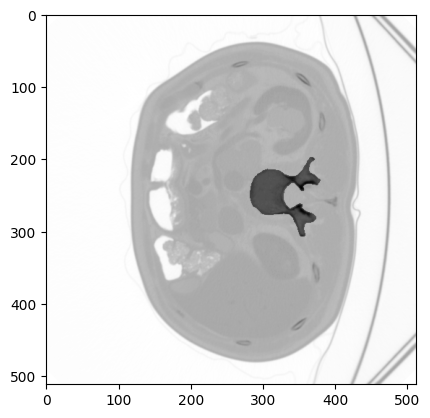

key_l1


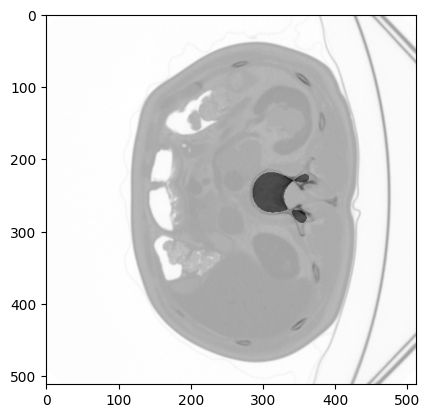

key_l1_thresh


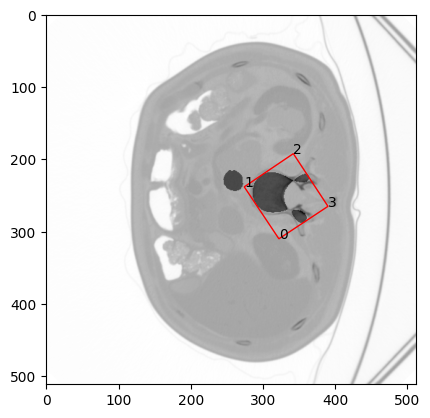

bounding_points


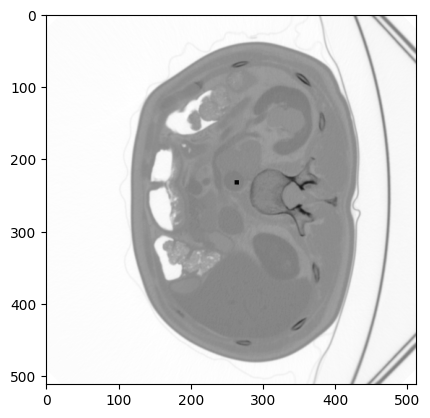

key_point: (264, 233)
L1 layers = [183, 221]. Key layer = 205
^
|
|
|

-------------------- Layer 205 -------------------
create_aorta_mask_return_center(ct, layer=205, estimated_aorta_center=(264, 233))


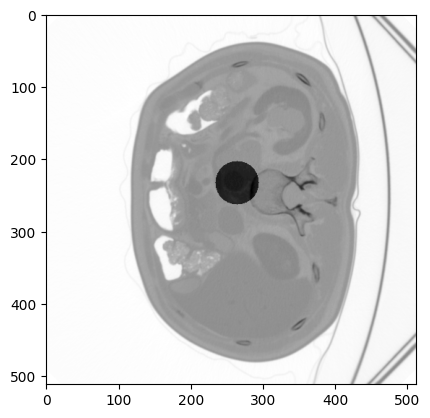

circle_mask


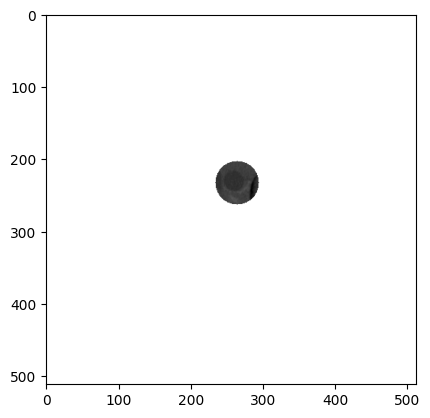

key_circle


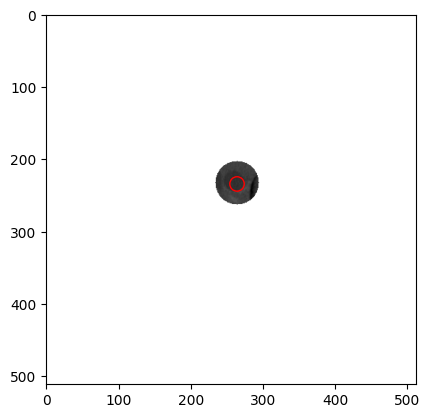

Estimated center: (264, 233)
Closest circle: (264,234), radius=10
aorta_circle: (264,234), r=10


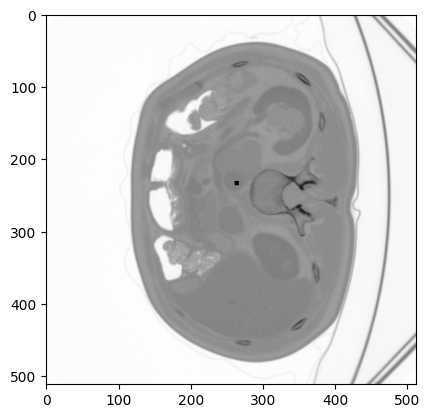

aorta_center: (264, 234)


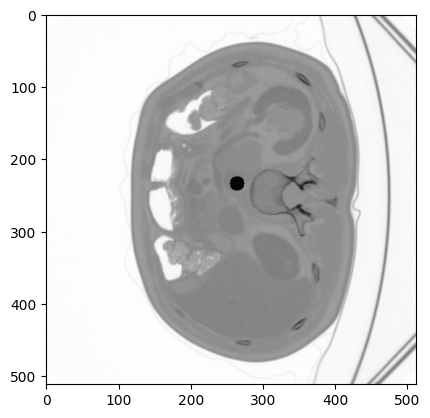

aorta_mask


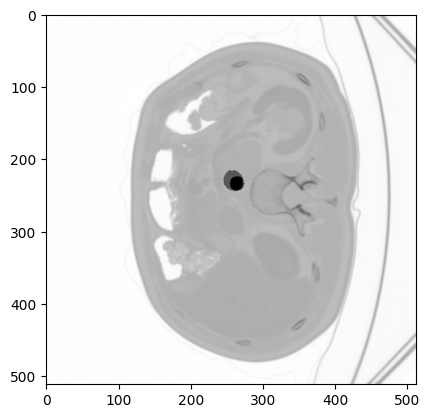

Aorta Ground Trurth vs Segmentation
-------------------- Layer 206 -------------------
create_aorta_mask_return_center(ct, layer=206, estimated_aorta_center=(264, 234))


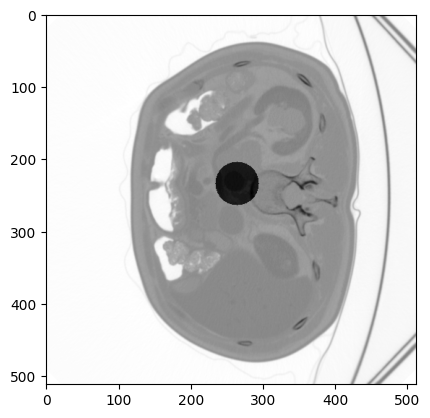

circle_mask


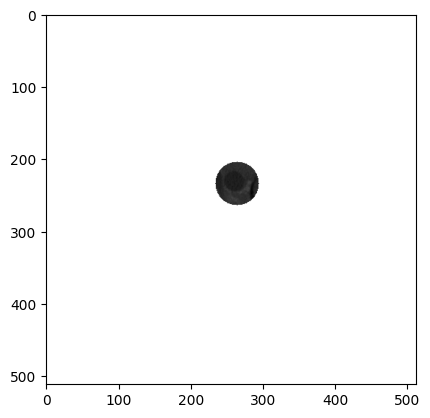

key_circle


KeyboardInterrupt: 

In [44]:
from skimage.filters.thresholding import threshold_otsu
from scipy.ndimage import gaussian_filter, binary_closing

# Show the keyframe for L1 in each CT scan, and the labeled Aorta next to it
for i in range(4):
    case_i = i + 1
    print(f"Case{case_i}")
    l1 = l1_data_list[i]
    ct = ct_data_list[i]
    aorta_GT = aorta_data_list[i]
    aorta_segmentation = np.zeros_like(ct)

    # Find key layer and key point in that layer
    bottom, top = get_first_and_last_nonzero_layers(l1)
    key_layer, aorta_center = get_key_layer_and_aorta_point_from_ct_and_l1(ct, l1)
    print(f"L1 layers = [{bottom}, {top}]. Key layer = {key_layer}")

    # Iterate up from the key layer and segment the aorta
    print("^\n"
          "|\n"
          "|\n"
          "|\n")
    for layer in range(key_layer, top, 1):
        print(f"-------------------- Layer {layer} -------------------")
        aorta_mask, aorta_center = create_aorta_mask_return_center(ct, layer, aorta_center, show_level=1)
        aorta_segmentation[:, :, layer] = aorta_mask
        ct_for_preview = ct[:, :, layer] / ct[:, :, layer].max()
        show(ct_for_preview + aorta_GT[:, :, layer] + aorta_mask, level=3)
        print("Aorta Ground Trurth vs Segmentation")

    # Iterate up from the key layer and segment the aorta
    print("|\n"
          "|\n"
          "|\n"
          "V\n")
    for layer in range(key_layer, bottom, -1):
        print(f"-------------------- Layer {layer} -------------------")
        aorta_mask, aorta_center = create_aorta_mask_return_center(ct, layer, aorta_center, show_level=1)
        aorta_segmentation[:, :, layer] = aorta_mask
        ct_for_preview = ct[:, :, layer] / ct[:, :, layer].max()
        show(ct_for_preview + aorta_GT[:, :, layer] + aorta_mask, level=3)
        print("Aorta Ground Trurth vs Segmentation")

    save_aorta_segmentation(aorta_segmentation, input_ct_path(case_i), ct_file_list[i])


In [40]:
SHOW_LEVEL = 0
def show(img, level=1):
    if (level >= SHOW_LEVEL):
        plt.imshow(img, cmap="gray_r")
        plt.show()


In [ ]:
import logging
import numpy as np

logging.basicConfig(level=logging.INFO)


def evaluate_segmentation(GT_seg, est_seg):
    """Calculate the DICE and VOD scores of two 3D numpy arrays.

    Args:
        GT_seg: A 3D numpy array containing the ground truth segmentation.
        est_seg: A 3D numpy array containing the estimated segmentation.

    Returns:
        A tuple with the DICE score and the VOD score.
    """
    # Convert the arrays to int type and ensure they have the same shape
    GT_seg = GT_seg.astype(int)
    est_seg = est_seg.astype(int)
    print(f"GT_seg shape={GT_seg.shape}")
    print(f"est_seg shape={est_seg.shape}")
    assert GT_seg.shape == est_seg.shape, "Arrays must have the same shape"

    # Calculate the DICE score
    intersection = np.sum(GT_seg * est_seg)
    GT_count = np.sum(GT_seg)
    est_count = np.sum(est_seg)
    dice = 2 * intersection / (GT_count + est_count)

    # Calculate the VOD score
    GT_unique, GT_counts = np.unique(GT_seg, return_counts=True)
    vod = 0
    for val, count in zip(GT_unique, GT_counts):
        # Ignore background pixels (assumed to have value 0)
        if val == 0:
            continue
        GT_seg_val = (GT_seg == val)
        est_seg_val = (est_seg == val)
        intersection = np.sum(GT_seg_val * est_seg_val)
        vod += intersection / count

    logging.info("DICE score: %.4f", dice)
    logging.info("VOD score: %.4f", vod)

    return dice, vod

In [ ]:
from common.nifti import load_nifti_data

GT_seg = load_nifti_data("data/Case1_Aorta.nii.gz")
est_seg = load_nifti_data("out/Case1_CT_Aorta_Segmentation.nii.gz")

In [ ]:
from common.plotting import show

show(est_seg[:, :, 210], level=3)
show(GT_seg[:, :, 210], level=3)

In [ ]:
from common.segmentation import get_first_and_last_nonzero_layers

l1_data = load_nifti_data("data/Case1_L1.nii.gz")
get_first_and_last_nonzero_layers(l1_data)

In [ ]:
def get_clipped_GT_seg(GT_seg, est_seg):
    # Find the indices of the slices with data in est_seg
    slice_indices = np.where(np.any(est_seg, axis=(0, 1)))[0]
    first_slice = slice_indices[0]
    last_slice = slice_indices[-1]
    print(f"slice_indices={slice_indices}")
    clipped_GT_seg = np.copy(GT_seg)
    clipped_GT_seg[:, :, :first_slice] = 0
    clipped_GT_seg[:, :, last_slice + 1:] = 0
    return clipped_GT_seg

In [ ]:
# Evaluate the segmentations using the function
clipped_GT_seg = get_clipped_GT_seg(GT_seg, est_seg)
VOD_result, DICE_result = evaluate_segmentation(clipped_GT_seg, est_seg)

# Print the results
print("VOD result:", VOD_result)
print("DICE result:", DICE_result)

In [ ]:

# Create some sample data for the GT and estimated segmentations
GT_seg_simple = np.array([[1, 1, 0, 1],
                          [1, 1, 1, 0],
                          [0, 1, 0, 1],
                          [1, 1, 1, 0]])

est_seg_simple = np.array([[1, 1, 0, 1],
                           [1, 0, 1, 0],
                           [0, 1, 0, 1],
                           [1, 1, 1, 0]])

In [ ]:
# Evaluate the segmentations using the function
VOD_result, DICE_result = evaluate_segmentation(GT_seg, est_seg)

# Print the results
print("VOD result:", VOD_result)
print("DICE result:", DICE_result)

In [ ]:
print(evaluate_segmentation(GT_seg, est_seg))